In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [3]:
AUDIO_DATA_PATH = "../../data/audio/intersetllar.mp3"

## 1. Extracción de Características de Audio

### a. Herramientas y Librerías  
* Librosa: Para análisis de audio.  
* PyDub: Para manipulación de archivos de audio.  
* Pre-trained Models: Como VGGish para características de audio más avanzadas.  

## Mel spectrogram

Un **Mel spectrogram** es una representación visual del contenido frecuencial de un archivo de audio, mapeado según la escala Mel, que es una escala perceptual que intenta reflejar cómo los humanos percibimos el sonido. Aquí tienes una guía para interpretarlo:

1. **Eje X (Tiempo)**:
   - Representa el progreso temporal del audio.
   - Cada punto a lo largo de este eje muestra qué frecuencias están presentes en un momento específico del tiempo.

2. **Eje Y (Frecuencias en Hz)**:
   - Muestra las diferentes frecuencias del audio, distribuidas según la escala Mel.
   - Las frecuencias más bajas están en la parte inferior y las más altas en la parte superior.

3. **Colores (Amplitud en dB)**:
   - Los colores indican la intensidad o energía de cada frecuencia en un momento específico.
   - **Colores cálidos (rojo/naranja):** Representan frecuencias con alta amplitud (más energía o volumen).
   - **Colores fríos (azul):** Representan frecuencias con baja amplitud (menos energía o volumen).

4. **Patrones comunes**:
   - **Barras verticales densas** suelen corresponder a sonidos transitorios, como golpes o percusiones.
   - **Zonas horizontales persistentes** indican tonos o frecuencias sostenidas, como un instrumento tocando una nota larga.
   - **Secciones claras y oscuras alternadas** pueden reflejar la variación dinámica del audio, como una canción con partes suaves y partes más enérgicas.

5. **Escala Mel**:
   - La escala Mel es no lineal, lo que significa que comprime las frecuencias más altas y expande las más bajas, para aproximarse a la percepción humana del sonido.

### ¿Qué puedes analizar?
- **Timbre**: Relacionado con los patrones únicos de frecuencias y cómo evolucionan en el tiempo.
- **Ritmo**: A partir de las repeticiones de patrones verticales.
- **Dinámica**: Observando las áreas más claras u oscuras en el espectrograma.
- **Identificación de eventos**: Puedes detectar momentos específicos de cambios o transiciones en el audio.

In [4]:
y, sr = librosa.load(AUDIO_DATA_PATH)

In [5]:
mel = librosa.feature.melspectrogram(y=y, sr=sr)

In [6]:
log_mel = librosa.power_to_db(mel, ref=np.max)

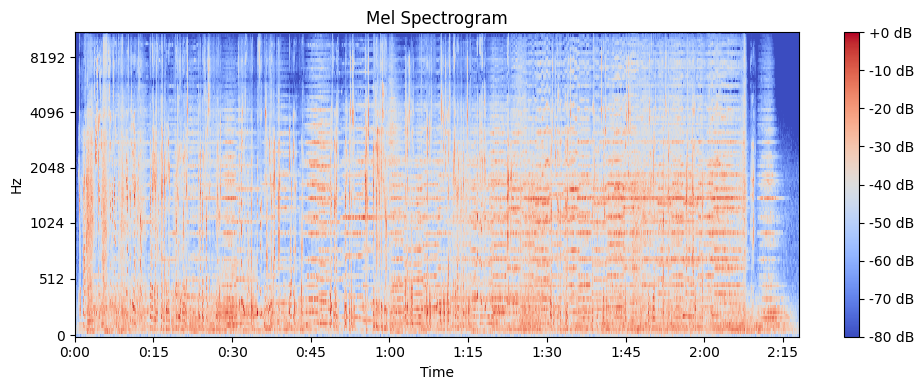

In [7]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

Cuando calculas el **promedio de la escala Mel** a lo largo de las columnas (usando `axis=1`), estás obteniendo un **resumen promedio de la energía de cada frecuencia** en todo el archivo de audio. Esto es útil para identificar las características generales del contenido frecuencial del audio.

### Interpretación de `mel_mean`:
1. **Vector resultante**:
   - El resultado es un vector donde cada valor representa la energía promedio de una frecuencia específica en la escala Mel a lo largo de todo el audio.
   - Si tienes, por ejemplo, 128 bandas Mel, `mel_mean` tendrá 128 valores.

2. **Frecuencias bajas vs altas**:
   - Valores más altos en bandas de frecuencias bajas (parte inicial del vector) indican que las frecuencias graves tienen más energía promedio.
   - Valores más altos en bandas de frecuencias altas (parte final del vector) sugieren que las frecuencias agudas dominan en el archivo de audio.

3. **Propósito del promedio**:
   - Permite entender el "perfil de frecuencia" general del audio.
   - Útil para tareas como clasificación de audio, detección de género musical o identificación de patrones tonales sin necesidad de analizar los detalles temporales.

### Ejemplo práctico:
- **Audio con más graves**: Tendrá valores más altos en las primeras posiciones de `mel_mean`.
- **Audio con más agudos**: Tendrá valores más altos en las últimas posiciones de `mel_mean`.
- **Audio balanceado**: Tendrá valores distribuidos uniformemente a lo largo del vector `mel_mean`.

In [8]:
mel_mean = np.mean(mel, axis=1)
mel_mean[:20]

array([0.00529787, 0.17023218, 0.65658647, 0.6040145 , 0.6228717 ,
       0.40545106, 0.7167027 , 0.8828679 , 1.2273515 , 0.856085  ,
       0.76726145, 0.4027271 , 0.39839718, 0.36830917, 0.23687163,
       0.15813814, 0.10721654, 0.26198965, 0.11576889, 0.09175829],
      dtype=float32)

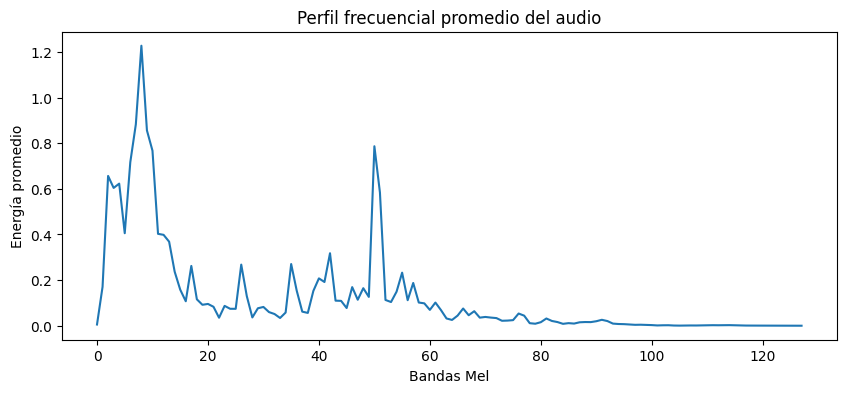

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(mel_mean)
plt.xlabel('Bandas Mel')
plt.ylabel('Energía promedio')
plt.title('Perfil frecuencial promedio del audio')
plt.show()

## MFCC

El **MFCC** (Mel-Frequency Cepstral Coefficients, por sus siglas en inglés) es una representación de características comúnmente utilizada en el procesamiento de señales de audio, especialmente en aplicaciones relacionadas con el análisis de voz, reconocimiento de habla y procesamiento musical. Este método traduce una señal de audio en un conjunto de características que son más relevantes para cómo los humanos perciben los sonidos.

### ¿Cómo funciona MFCC?

1. **Preprocesamiento de la señal**:
   - **Ventaneo**: Se divide la señal de audio en segmentos (ventanas) pequeños, típicamente de 20-40 ms, para capturar características locales de tiempo y frecuencia. Esto ayuda a analizar cómo varía la energía del sonido en diferentes frecuencias.
   - **Remoción de DC**: Se elimina la componente de frecuencia cero para evitar problemas en el análisis.

2. **Transformada de Fourier**:
   - Se aplica la transformada rápida de Fourier (FFT) a cada ventana para convertir la señal del dominio del tiempo al dominio de la frecuencia.

3. **Banco de filtros Mel**:
   - Se pasa la señal a través de un conjunto de filtros distribuidos en la escala **Mel**, que simula cómo el oído humano percibe las frecuencias. 
   - La escala Mel es logarítmica para frecuencias altas y lineal para frecuencias bajas, reflejando la sensibilidad auditiva humana.

4. **Logaritmo de la energía**:
   - Se calcula el logaritmo de la energía en cada banda del banco de filtros para captar mejor la percepción no lineal del sonido.

5. **Transformada Coseno Discreta (DCT)**:
   - Se aplica la DCT a los valores logarítmicos de las energías para comprimir los datos y reducir la correlación entre características.
   - Esto produce los coeficientes cepstrales, que son los MFCC.

6. **Selección de coeficientes**:
   - De los coeficientes generados, solo los primeros (entre 12 y 20 típicamente) son retenidos, ya que capturan las características más relevantes del espectro sonoro.

### ¿Por qué es útil el MFCC?
- **Imita la percepción humana**: La escala Mel aproxima cómo las frecuencias son percibidas por el oído humano, haciendo que las características extraídas sean más relevantes para tareas como reconocimiento de voz o identificación de música.
- **Reduce dimensionalidad**: Al seleccionar solo unos pocos coeficientes, se reducen significativamente los datos a analizar, manteniendo la información importante.
- **Amplia aplicabilidad**: Es ampliamente utilizado en sistemas de reconocimiento de habla, análisis de emociones en audio, clasificación de géneros musicales y otras aplicaciones de procesamiento de audio.

In [10]:
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
mfcc_mean = np.mean(mfcc, axis=1)
print(mfcc_mean)
print(len(mfcc_mean))

[-265.1951     106.55001    -31.41273     21.747341    11.188025
   16.199648     5.087622     2.2845664   -9.942396     5.335772
  -13.114447     4.052068   -12.5956955]
13


## Chroma

El **Chroma** en el análisis de audio es una representación de las características tonales de una señal, basada en la percepción musical. Se refiere a cómo se distribuyen las frecuencias de una señal a lo largo de las **12 clases de tono** de una octava (las notas musicales: C, C#, D, D#, E, F, F#, G, G#, A, A#, B), ignorando el componente de octava. Esto significa que dos notas separadas por una o más octavas (por ejemplo, C3 y C4) serán representadas de manera similar en la representación Chroma.

### Función `librosa.feature.chroma_stft`
La función `librosa.feature.chroma_stft` calcula un espectrograma Chroma a partir de una señal de audio, utilizando la Transformada de Fourier a corto plazo (STFT) para analizar el contenido espectral. Este análisis es útil en aplicaciones como:

1. **Identificación de tono y acordes**.
2. **Análisis armónico**.
3. **Clasificación de música**.
4. **Sincronización de contenido musical**.

### Parámetros principales:
- **`y`**: La señal de audio de entrada (array de amplitudes en el dominio temporal).
- **`sr`**: La frecuencia de muestreo (en Hz) de la señal de audio.
- Otros parámetros, opcionales, permiten personalizar el cálculo del espectrograma y la conversión a Chroma.

### ¿Por qué es importante?
El Chroma es especialmente relevante en el análisis musical porque:
- Permite capturar la tonalidad y armonía de la música.
- Ignora detalles relacionados con la intensidad y la octava, lo que hace que sea más robusto frente a cambios de timbre.
- Facilita tareas de detección de acordes, estructuras armónicas y comparación de melodías.

Si estás trabajando en análisis emocional de audio o recomendación musical (como en tu proyecto de embeddings multimodales), el espectrograma Chroma puede ser una característica clave para representar las emociones o estilos armónicos.

In [11]:
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
chroma_mean = np.mean(chroma, axis=1)
chroma_mean[:20]

array([0.40432522, 0.42431116, 0.3010228 , 0.29221538, 0.34796062,
       0.6373501 , 0.34655765, 0.363603  , 0.3370268 , 0.32561478,
       0.47835878, 0.32516685], dtype=float32)

## Tempo

El **tempo** es una medida de la velocidad de una pieza musical y se expresa comúnmente en beats por minuto (**BPM**). Representa la cantidad de pulsos o latidos que se producen en un minuto, lo que determina cuán rápida o lenta es la música.

En **Librosa**, la función `librosa.beat.beat_track(y=y, sr=sr)` se utiliza para analizar un archivo de audio y estimar su tempo, junto con identificar las posiciones de los beats en el tiempo.

### Parámetros principales:
- **`y`**: Es el array de muestras de audio (el señal de audio).
- **`sr`**: La tasa de muestreo del audio (samples per second).

### Resultados que retorna:
La función devuelve dos valores:
1. **`tempo`**: Un flotante que representa el tempo estimado del audio en BPM.
2. **`beat_frames`**: Un arreglo que contiene los índices de los beats detectados en términos de frames.

### Aplicaciones:
1. Análisis musical.
2. Sincronización de efectos visuales o auditivos.
3. Procesamiento de audio para estimar y modificar el tempo.

### Nota:
La precisión del `tempo` depende de la calidad del audio y la claridad del ritmo. Si el audio es complejo o tiene muchas variaciones, es posible que el estimado no sea completamente exacto.

In [12]:
tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
tempo

array([123.046875])

## Zero Crossing Rate (ZCR)

El **Zero Crossing Rate (ZCR)** o tasa de cruce por cero es una métrica comúnmente utilizada en el procesamiento de señales, especialmente en audio. Representa la cantidad de veces que una señal de audio cruza el eje de cero (cambia de positivo a negativo o viceversa) en un intervalo de tiempo. Es particularmente útil para analizar señales relacionadas con la *tonalidad* y el *ruido*.

### Aplicaciones
- En audio, un ZCR alto indica típicamente una señal con alta frecuencia o ruido, como consonantes fricativas o ruido blanco.
- Un ZCR bajo se asocia más comúnmente con señales suaves o tonos constantes, como vocales en una canción.

### Notas
- Si la señal de audio contiene múltiples canales (estéreo), debes convertirla a mono con `librosa.to_mono` antes de calcular el ZCR.
- El ZCR no capta información tonal o armónica, por lo que suele combinarse con otras características como MFCC para análisis más detallados.

In [13]:
# Zero Crossing Rate
zcr = librosa.feature.zero_crossing_rate(y)
zcr_mean = np.mean(zcr)
zcr_mean

np.float64(0.11555808920913219)

## Spectral Centroid

El **Spectral Centroid** (centroide espectral) es una medida que describe el centro de "gravedad" del espectro de frecuencias de una señal. En términos simples, indica dónde se concentra la mayor parte de la energía del espectro, y es útil para identificar si un sonido es "brillante" o "oscuro". Es una característica importante en el análisis de audio y música, ya que está asociada con el timbre y la percepción del brillo del sonido.

### Fórmula Matemática
El Spectral Centroid se calcula como:


$$\text{Centroid} = \frac{\sum_{k=1}^{N} f_k \cdot |X_k|}{\sum_{k=1}^{N} |X_k|}$$

Donde:
- $( f_k )$: Frecuencia asociada a cada bin del espectro.
- $( |X_k| )$: Magnitud del espectro en ese bin.
- $( N )$: Número total de bins.

Básicamente, es un promedio ponderado de las frecuencias, donde el peso de cada frecuencia es su magnitud espectral.

---

### Uso en `librosa`
En **`librosa`**, el método `librosa.feature.spectral_centroid` calcula el Spectral Centroid de una señal. Su sintaxis básica es:

```python
librosa.feature.spectral_centroid(y=None, sr=22050, S=None, n_fft=2048, hop_length=512, freq=None)
```

#### Parámetros principales:
- **`y`**: La señal de audio de entrada (unidimensional).
- **`sr`**: Frecuencia de muestreo de la señal (`22050` por defecto).
- **`S`**: Espectrograma precomputado (opcional, si ya tienes uno calculado).
- **`n_fft`**: Tamaño de la ventana FFT (2048 por defecto).
- **`hop_length`**: Cantidad de muestras entre ventanas sucesivas (512 por defecto).
- **`freq`**: Vector de frecuencias (opcional, útil si el espectro tiene un eje de frecuencia no lineal).

#### Salida:
Devuelve un arreglo con los valores del Spectral Centroid para cada ventana de tiempo en la señal.

### Interpretación
- **Bajos valores** del Spectral Centroid indican sonidos con más energía en frecuencias bajas (sonidos graves).
- **Altos valores** indican sonidos con más energía en frecuencias altas (sonidos agudos).

Esta característica se utiliza ampliamente en análisis de audio, clasificación musical, y síntesis de sonido.

In [14]:
# Spectral Centroid
spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
spec_centroid_mean = np.mean(spec_centroid)
spec_centroid_mean

np.float64(2037.6877138901075)

In [20]:
normalized_wave = y / np.max(np.abs(y)) * np.max(spec_centroid)

In [15]:
frames = range(len(spec_centroid[0]))
times = librosa.frames_to_time(frames, sr=sr)

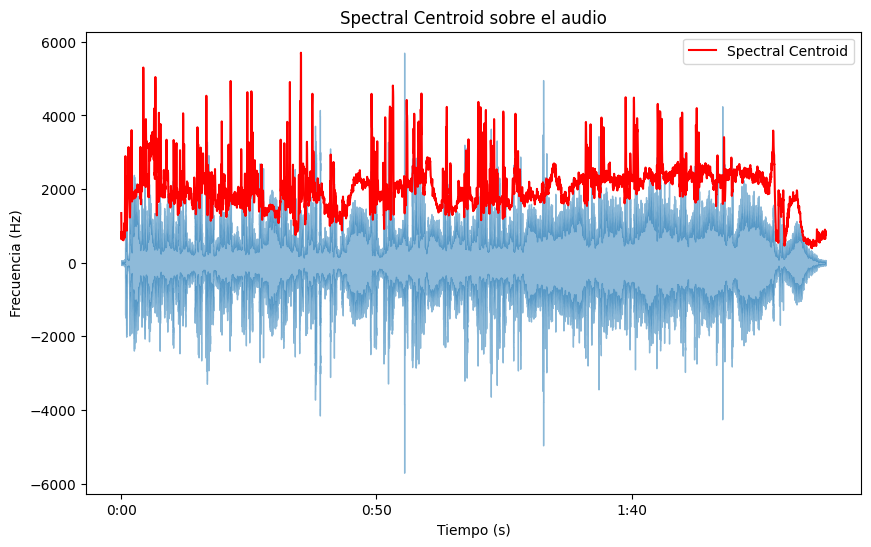

In [22]:
plt.figure(figsize=(10, 6))
librosa.display.waveshow(normalized_wave, sr=sr, alpha=0.5)
plt.plot(times, spec_centroid[0], color='r', label='Spectral Centroid')
plt.legend(loc='upper right')
plt.title('Spectral Centroid sobre el audio')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia (Hz)')
plt.show()
